In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import seaborn as sns
import splitfolders
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
cwd = os.getcwd() # Getting current directory
break_dir = cwd + '\\Break'
normal_dir = cwd + '\\Normal'
data_dict = {}
for filename in os.listdir(normal_dir):
    if filename.endswith(".txt") and filename !="Read me.txt":
        filepath = os.path.join(normal_dir,filename)
        arr_name = os.path.splitext(filename)[0]
        data_arr = np.loadtxt(filepath)
        data_dict[arr_name] = data_arr

In [3]:
for key in data_dict:
    print(key)

DualOn2000RPM1_Normal
DualOn3000RPM1_Normal
FFT_Won3000RPM1_Normal
Freq_Won3000RPM1_Normal
Won2000RPM1_Normal
Won3000RPM1_Normal
Zon2000RPM1_Fs5k_Normal
Zon3000RPM1_Normal


In [4]:
Won3000RPM1_Normal = data_dict["Won3000RPM1_Normal"][:,1].tolist()
t = data_dict["Won3000RPM1_Normal"][:,0].tolist()
print(len(Won3000RPM1_Normal))
print(len(t))

1008384
1008384


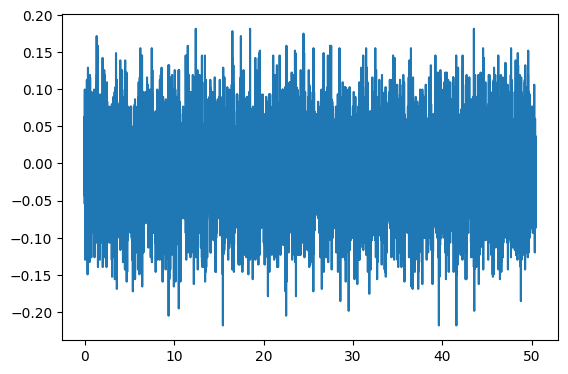

In [5]:
plt.subplots_adjust(bottom=0.2)
ax = plt.gca()
plt.plot(t, Won3000RPM1_Normal)
plt.show()

In [6]:
FFT_Won3000RPM1_Normal = data_dict["FFT_Won3000RPM1_Normal"]
f = data_dict["Freq_Won3000RPM1_Normal"].tolist()
print(FFT_Won3000RPM1_Normal.shape)
print(len(f))
x_train = np.expand_dims(FFT_Won3000RPM1_Normal, axis=2)
print(x_train.shape)

(537, 1251)
1251
(537, 1251, 1)


In [7]:
device =torch.device("cuda:0" if torch.cuda.is_available() else "Cpu")
print(torch.version.cuda)

11.8


In [8]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32) # Convert data from numpy to torch tensors

# Create a dataset and split for validation
dataset = TensorDataset(x_train_tensor, x_train_tensor)  # Autoencoder: input == target

val_size = int(0.1 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:
n_steps = x_train.shape[1] #2501 columns
n_features = x_train.shape[2] # = 1 layer

class ConvLSTMAutoencoder(nn.Module):
    def __init__(self, n_steps, n_features):
        super(ConvLSTMAutoencoder, self).__init__() # Inheriting from base class nn.Module, lấy những methods cần thiết chứ không bê tất
        self.n_steps = n_steps
        self.n_features = n_features

        # Conv1D encoder layer
        self.conv1 = nn.Conv1d(
            in_channels=n_features,
            out_channels=16,
            kernel_size=10,
            padding='same',  # Use manual padding below
            dilation=1
        )

        # LSTM encoder
        self.lstm1 = nn.LSTM(
            input_size=16,
            hidden_size=8,
            batch_first=True
        )

        # LSTM decoder
        self.lstm2 = nn.LSTM(
            input_size=8,
            hidden_size=8,
            batch_first=True
        )

        # Conv1D decoder layer
        self.conv2 = nn.Conv1d(
            in_channels=8,
            out_channels=16,
            kernel_size=10,
            padding='same',
            dilation=1
        )

        # TimeDistributed Dense(1)
        self.fc = nn.Linear(16, 1)

    def forward(self, x): #the process of passing input data through the layers of a neural network to obtain an output
        # Input shape: (batch_size, n_steps, n_features)
        # Conv1D in PyTorch expects: (batch_size, channels=n_features, seq_len=n_steps)
        x = x.permute(0, 2, 1)  # (B = 128, C, T), batch size would be set up later, rearrange the input size
        x = self.conv1(x)
        x = x.permute(0, 2, 1)  # rearrange back to (B, T, C) for LSTM

        # LSTM encoder
        _, (h_n, _) = self.lstm1(x)
        h = h_n[0]  # (B, hidden)

        # RepeatVector
        h_repeated = h.unsqueeze(1).repeat(1, self.n_steps, 1)  # (B, T, hidden)

        # LSTM decoder
        x_decoded, _ = self.lstm2(h_repeated)

        # Conv1D decoder
        x_decoded = x_decoded.permute(0, 2, 1)  # (B =128, C=25, T)
        x_decoded = self.conv2(x_decoded)

        # Final TimeDistributed Dense layer
        x_decoded = x_decoded.permute(0, 2, 1)  # (B, T, C=32)
        output = self.fc(x_decoded)  # (B, T, 1)

        return output
model = ConvLSTMAutoencoder(n_steps=n_steps, n_features=n_features)
model.to(device)  # Move model to GPU or CPU

# Optimizer and Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Print summary-like info
print(model)

ConvLSTMAutoencoder(
  (conv1): Conv1d(1, 16, kernel_size=(10,), stride=(1,), padding=same)
  (lstm1): LSTM(16, 8, batch_first=True)
  (lstm2): LSTM(8, 8, batch_first=True)
  (conv2): Conv1d(8, 16, kernel_size=(10,), stride=(1,), padding=same)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)


In [10]:
# Initialize training setup
epochs = 100
patience = 25
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_state = None
train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0


    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_x.size(0)

    train_loss /= len(train_loader.dataset)
    


    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item() * batch_x.size(0)

    val_loss /= len(val_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

# Restore best model weights
if best_model_state is not None:
    model.load_state_dict(best_model_state)

Epoch 1/100 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 2/100 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 3/100 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 4/100 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 5/100 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 6/100 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 7/100 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 8/100 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 9/100 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 10/100 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 11/100 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 12/100 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 13/100 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 14/100 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 15/100 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 16/100 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 17/100 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 18/100 - Train Loss: 0.0000 - Val Loss: 0.0000
Epoch 19/100 - Train Loss: 0.0000 - Val Loss: 0.0000
Ep

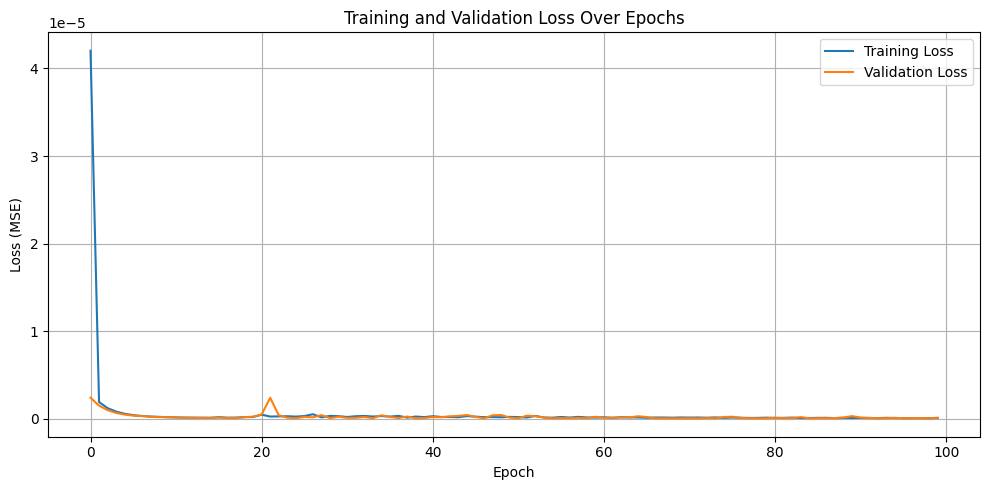

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

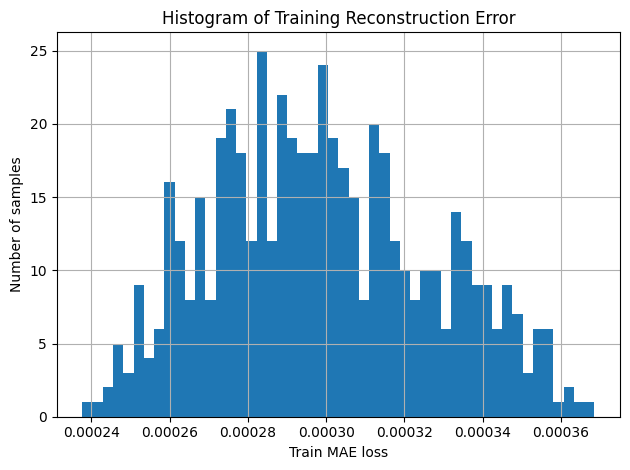

Reconstruction error threshold: 0.00036858613


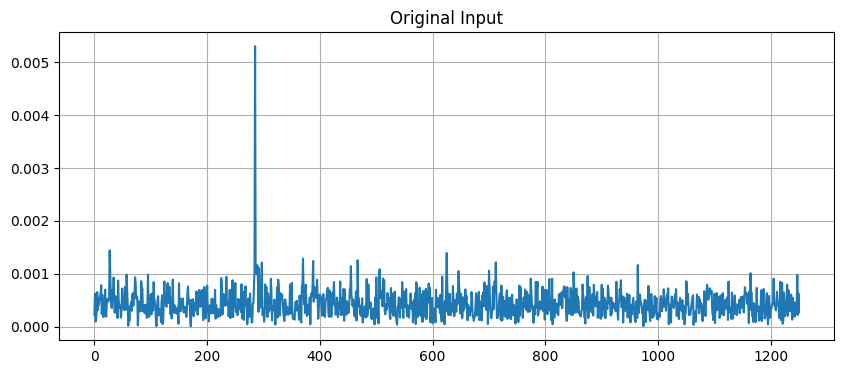

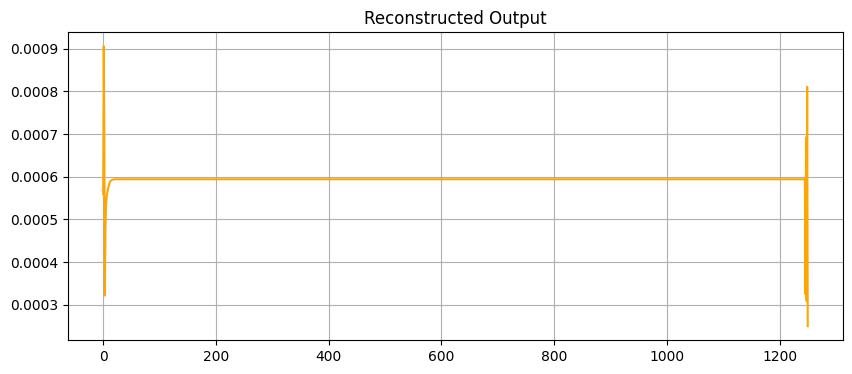

In [12]:
torch.cuda.memory_summary(device=None, abbreviated=False)
# Make sure model is in eval mode and data is on correct device
model.eval()
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)

# 1. Predict training data
with torch.no_grad():
    x_train_pred = model(x_train_tensor)

# 2. Move tensors to CPU and convert to NumPy
x_train_pred_np = x_train_pred.cpu().numpy()
x_train_np = x_train_tensor.cpu().numpy()

# 3. Compute MAE per sample (mean over all time steps and features)
# Assume shape is (batch_size, time_steps, features)
train_mae_loss = np.mean(np.abs(x_train_pred_np - x_train_np), axis=(1, 2))  # axis=1 for time only, or (1,2) for full sequence

# 4. Plot histogram of reconstruction loss
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("Number of samples")
plt.title("Histogram of Training Reconstruction Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Set anomaly threshold
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold:", threshold)

# 6. Plot first input vs reconstruction
plt.figure(figsize=(10, 4))
plt.plot(x_train_np[100], label="Original")
plt.title("Original Input")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(x_train_pred_np[100], label="Reconstruction", color='orange')
plt.title("Reconstructed Output")
plt.grid(True)
plt.show()